In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA, ARMA
import statsmodels.tsa.arima_model  
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt 
import seaborn as sns
import pylab
import scipy
import yfinance
from arch import arch_model
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

# to ignore some warnings in python when fitting models ARMA or ARIMA
import warnings 
warnings.filterwarnings('ignore')

# TIME SERIES ANALYSIS OF BITCOIN, GOLD AND CRUDE OIL PRICES

## Brief Methodology

### Methodology

The first part of this project is to analyze three time series to find out the characteristics of Bitcoin, Gold and Crude Oil prices and theirs returns, as well as propose suitable models for forecasting purposes. Among many approaches, the ARIMA model for stationary series and GARCH model for capturing the volatility are used in this project: 

- ARMA model: 
$$X_{t}=c+\epsilon_{t}+\sum_{i=1}^{p}\phi_{i}X_{t-i}+\sum_{i=1}^{q}\theta_{i}\epsilon_{t-i}$$


- GARCH model:
$$ X_t = \mu + Y_t$$
$$Y_t = \sigma_t\epsilon_t$$
$$\sigma_t^2 = \omega + \sum_{j=1}^k\beta_j\sigma_{t-j}^2 + \sum_{i=1}^h\alpha_iY_{t-i}^2$$

- ARMA-GARCH model:
$$ X_t = \mu +\sum_{i=1}^{p}\phi_{i}X_{t-i}+ Y_t + \sum_{j=1}^{q}.\theta_jY_{t-j}$$

$$Y_t = \sigma_t\epsilon_t$$

$$\sigma_t^2 = \omega + \sum_{j=1}^k\alpha_jY_{t-j}^2 + \sum_{i=1}^h\beta_i\sigma_{t-i}^2$$

- The Box–Jenkins methodology is used to find the suitable model ARIMA(p,d,q):
    - Step 1: Model identification: examine the stationarity of the times series, identify levels of differencing d, and then find p and q orders.
    - Step 2: Model estimation: Choosing the possible models by examining the coefficients and information criteria (AIC, BIC).
    - Step 3: Model checking via residuals if it resembles the white noise with zero mean, constant variance, no correlation and also should be normal distribution. If yes, we can use the model for forecasting. Otherwise, we come back to step 2 to choose another modified model.
    
- If there is a sign of volatility clustering in the data, we will consider the GARCH model to capture it. ARCH test will be used to indicate the conditional variance in the data.
    
- In this project, a significance level of 5% is chosen.

### Tests Used In The Project

There are some tests used in this part, which are briefly described as below: 

1) The Augmented Dickey-Fuller test is used to check the stationarity of a time series:
* H0: the time series has a unit root, meaning it is non-stationary.
* H1: the time series does not have a unit root, meaning it is stationary.
* Interpretation: If test results indicate p-value < 0.05: Reject the null hypothesis. If p-value > 0.05: we do not have enough evidence to reject the null hypothesis.

2) A time series have ARCH effects means it has conditional heteroscedasticity or autocorrelation in its squared series. Engle’s ARCH Test is used with:
* H0: The squared residuals have no ARCH effects.
* H1: The squared residuals have ARCH effects.
* Interpretation: If test results indicate p-value < 0.05: Reject the null hypothesis. If p-value > 0.05: we do not have enough evidence to reject the null hypothesis.

3) The Ljung-Box test is used to examine the autocorrelation in time-series residuals:
* H0: The residuals has no autocorrelation. 
* H1: The residuals exhibit serial correlation.
* Interpretation: If p-value > 0.05, we do not have enough statistical evidence to reject the null hypothesis.

4) The Shapiro-Wilks test:
* H0 : The data is normally distributed
* H1 : The data is not normally distributed
* Interpretation: If p-value < 0.05, we can reject the null hypothesis.

## Data Pre-processing

- Source of Data: Yahoo Finance
- Risky assets of Group 5 are: 
    - Bitcoin (BTC-USD) Historical Price.
    - Gold (GC=F) Stock Historical Prices.
    - Crude Oil(CL=F) Stock Historical Prices.
    
- Timeframe of all series: 2018-06-18 to 2021-06-18.
- The adjusted close price are used in the project, which are called prices for short.
- The currency units are converted from USD to EUR

In [2]:
# Import data
data = yfinance.download(tickers= 'BTC-USD, GC=F, CL=F, EURUSD=X', 
                         start="2018-06-19", end="2021-06-19", 
                         group_by='column', treads=True)['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [3]:
data

,BTC-USD,CL=F,EURUSD=X,GC=F
Date,,,,
2018-06-18,6734.819824,65.849998,1.159595,1276.199951
2018-06-19,6769.939941,65.070000,1.163075,1275.599976
2018-06-20,6776.549805,66.220001,1.158856,1271.199951
2018-06-21,6729.740234,65.540001,1.157903,1267.199951
2018-06-22,6083.689941,68.580002,1.160578,1267.400024
...,...,...,...,...
2021-06-14,40218.476562,70.879997,1.211020,1864.000000
2021-06-15,40406.269531,72.120003,1.212224,1854.500000
2021-06-16,38347.062500,72.150002,1.212709,1859.500000


In [4]:
# Check the number of missing values of the raw data
data.isna().sum()

BTC-USD       4
CL=F        348
EURUSD=X    333
GC=F        348
dtype: int64

While Bitcoin series has 4 missing values, the series of Gold, Crude oil and the exchange rate EUR/USD has 348, 348 and 333 missing values respectively.

In [5]:
# Handing the missing value of the exchange rate by the method of backward fill before convert other price series into Euro
data['EURUSD=X'].fillna(method='bfill', inplace=True) 
# Check the number of missing values again
data.isna().sum()

BTC-USD       4
CL=F        348
EURUSD=X      0
GC=F        348
dtype: int64

The purpose of handling the missing value of the exchange rate EUR/USD with the method of the backward fill is to make sure that there will be enough data to convert the price currency from USD to EUR, especially when the missing data of the exchange rate is much larger than that of the Bitcoin series.

In [6]:
# Convert currency from USD to EUR
data['btc'] = data['BTC-USD']/data['EURUSD=X']
data['gold'] = data['GC=F']/data['EURUSD=X']
data['oil'] = data['CL=F']/data['EURUSD=X']

In [7]:
# Separate series for easily roeking 
df1 = data['btc']
df2 = data['gold']
df3 = data['oil']
# Convert from Series to DataFrame
df1 = df1.to_frame()
df2 = df2.to_frame()
df3 = df3.to_frame()

In [8]:
# Drop the missing values in each series
df1.dropna(axis=0, inplace=True)
df2.dropna(axis=0, inplace=True)
df3.dropna(axis=0, inplace=True)

##  Preliminary Analysis

### Descriptive Statistics

In [9]:
df1.describe()

,btc
count,1093.000000
mean,12351.855249
std,12159.234201
min,2853.386707
25%,5688.257023
50%,8081.206054
75%,9980.147078
max,53298.451848


In [10]:
df2.describe()

,gold
count,749.000000
mean,1353.377120
std,203.281514
min,1006.338327
25%,1146.699577
50%,1373.266323
75%,1534.825044
max,1727.896375


In [11]:
df3.describe()

,oil
count,749.000000
mean,46.330974
std,11.181283
min,-34.627881
25%,37.673539
50%,49.537480
75%,53.889193
max,66.145847


- After pre-processing the data, the Bitcoin price series has 1093 observations, while the series of Gold price and Crude oil price data have 749 observations each. This difference stems from the fact that the Bitcoin series data is recorded in frequency of 7 days, while the frequency of Gold, Oil, and the exchange rate EUR/USD data are recorded in business days only (no Saturday and Sunday).
- The range of prices are from €2853.386 to €53298.451 for Bitcoin, from €1006.338 to €1727.896 per ounce for Gold, and from €-34.627 to €66.145 per barrel for Crude oil. Among three time series, only Crude oil prices series has negative prices. 
- The Bitcoin series is the highest volatility (standard deviation of the series is 12159.23), while Crude oil prices only have the standard deviation of 11.18.

##### Time plot of the prices

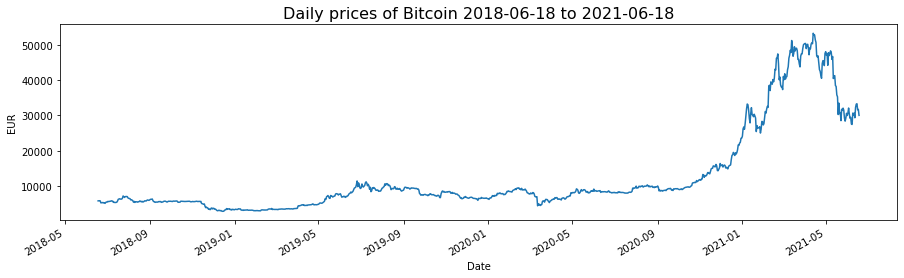

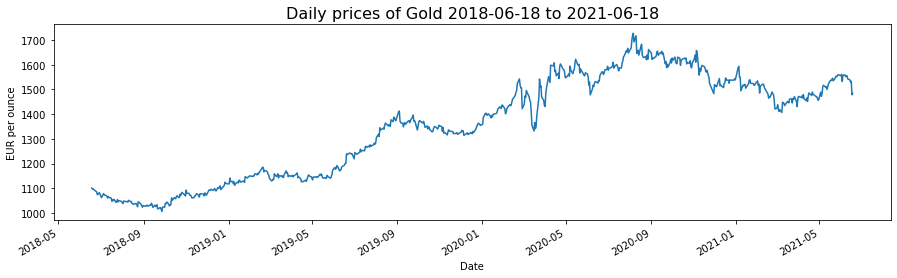

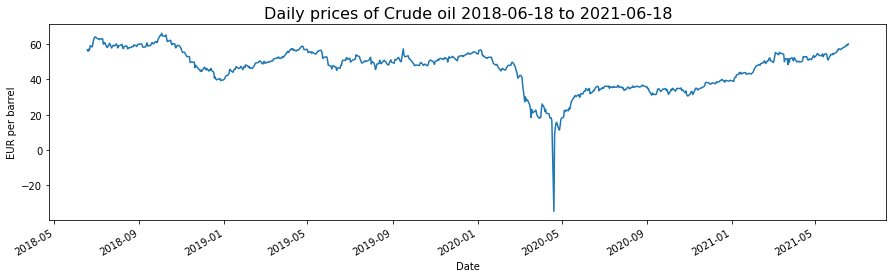

In [12]:
# Due to different magnitudes of each series, I seperate them in 3 plots to examine the volatility closely
# Bitcoin prices
df1.btc.plot(figsize=(15,4))
plt.ylabel("EUR")
plt.title('Daily prices of Bitcoin 2018-06-18 to 2021-06-18', fontsize=16)
plt.show()

# Gold prices
df2.gold.plot(figsize=(15,4))
plt.ylabel("EUR per ounce")
plt.title('Daily prices of Gold 2018-06-18 to 2021-06-18', fontsize=16)
plt.show()

# Oil prices
df3.oil.plot(figsize=(15,4))
plt.ylabel("EUR per barrel")
plt.title('Daily prices of Crude oil 2018-06-18 to 2021-06-18', fontsize=16)
plt.show()

- There is no sign of seasonal components from three plots.

- Bitcoin price series: From 2018 to 2121, there was an upward trend in the plot. The prices reached the peak of €53298.45 in April 2021. After that time, the prices of Bitcoin began to fall down significantly. This overall trend can be explained by the fact that many organizations accept Bitcoin as a means of purchasing or payment like Paypal or Tesla.      

- Gold price series: During the period from June 2018 to August 2021, the graph showed an upward trend, following by the peak of €1727.896 per ounce in September 2020. Afterwards, the figures decreased in the rest of the time.
  
- Oil price series: At the end of 2018, the prices declined before increasing again in 2019. In April 2020 there was a sharp decrease in the first six months of the year. After that the prices went up until June 2021. 
    - Events that can affect the oil prices: (1) The minimal volatility in 2019 due to "rising geopolitical tensions in several oil producing countries, as well as trade tensions between major economies" (like China and the USA). (2) In March 2020, the oil price war between Russia and Saudi Arabia on disagreement of the oil production levels, leading to the drop in April. Also in April the war ended, the prices recovered. The negative prices occurred because producers paid consumers to come and take the oil before the mature date of contracts in May. 
    - This negative abnormal points can be seen as outliers in the data. However, they are a natural part of the oil prices, so we keep them in the data. 

Sources:  
- The OPEC Annual report 2019, 2020: https://www.opec.org/opec_web/en/publications/337.htm
- https://www.investopedia.com/articles/investing/100615/will-oil-prices-go-2017.asp
- https://finance.yahoo.com/news/negative-oil-prices-already-084101013.html

##### Rolling descriptive statistics

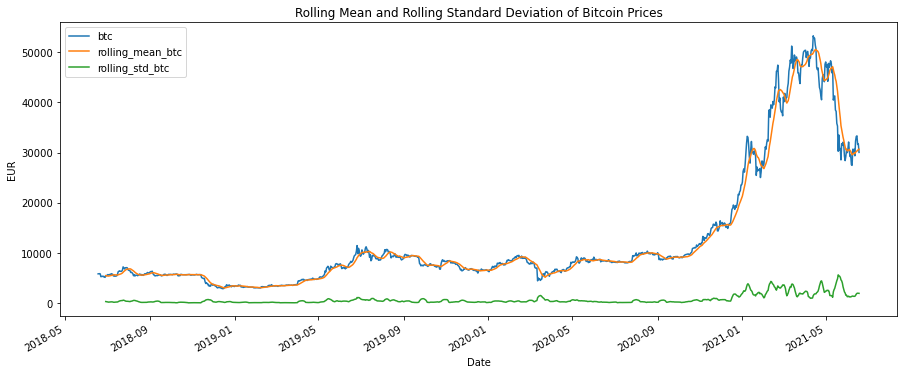

In [13]:
df1['rolling_mean_btc'] = df1.btc.rolling(window=12).mean()
df1['rolling_std_btc'] = df1.btc.rolling(window=12).std()
df1.plot(title='Rolling Mean and Rolling Standard Deviation of Bitcoin Prices', 
         figsize=(15,6))
plt.ylabel("EUR")
plt.show()

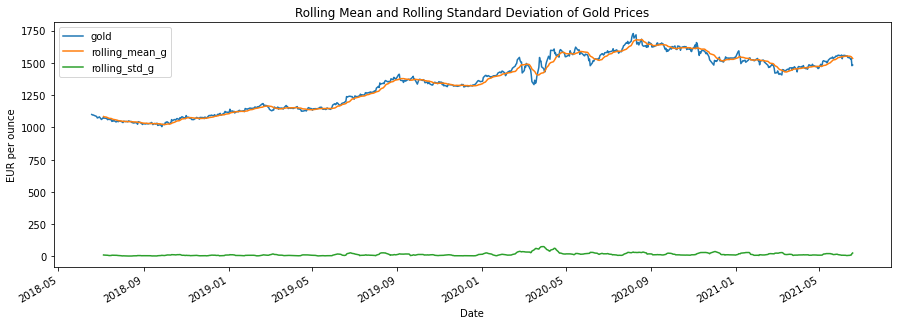

In [14]:
df2['rolling_mean_g'] = df2.gold.rolling(window=12).mean()
df2['rolling_std_g'] = df2.gold.rolling(window=12).std()
df2.plot(title='Rolling Mean and Rolling Standard Deviation of Gold Prices',figsize=(15,5))
plt.ylabel('EUR per ounce')
plt.show()

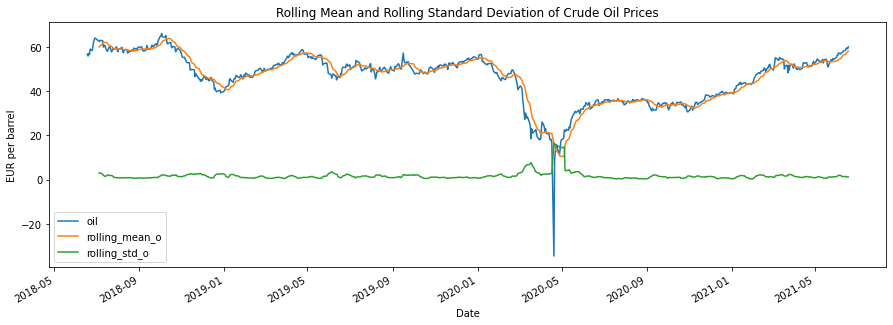

In [15]:
df3['rolling_mean_o'] = df3.oil.rolling(window=12).mean()
df3['rolling_std_o'] = df3.oil.rolling(window=12).std()
df3.plot(title='Rolling Mean and Rolling Standard Deviation of Crude Oil Prices', 
         figsize=(15,5))
plt.ylabel('EUR per barrel')
plt.show()

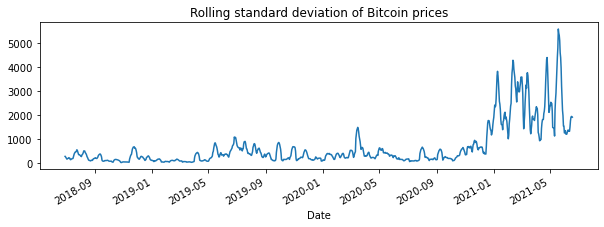

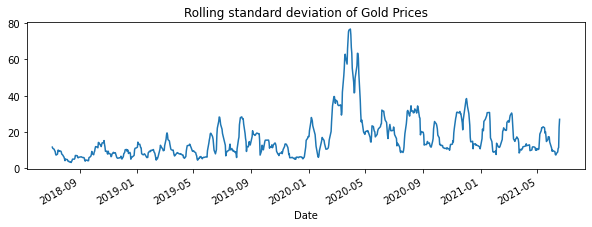

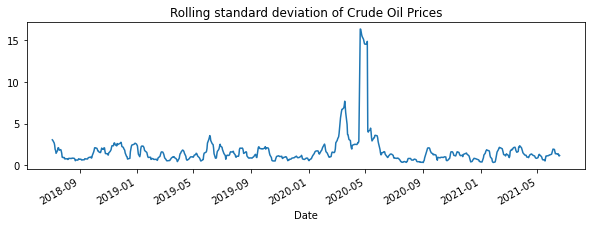

In [16]:
# The rolling standard deviation in separated plots
df1['rolling_std_btc'].plot(title='Rolling standard deviation of Bitcoin prices', figsize=(10,3))
plt.show()
df2['rolling_std_g'].plot(title='Rolling standard deviation of Gold Prices', figsize=(10,3))
plt.show()
df3['rolling_std_o'].plot(title='Rolling standard deviation of Crude Oil Prices', figsize=(10,3))
plt.show()

From the plots, we can see the mean and variance of each series are not constant over the entire sample. 

- Bitcoin prices:
Overall, the rolling mean is increased non-linear. The rolling standard deviation had minimal fluctuated until the end of 2020. Since 2021 it has became much varied. We consider decomposing the data with a multiplicative method.

- Gold prices: 
The plots show that the rolling mean of the entire series has an upward trend. The variation was quite remarkable, especially in the first 6 months of the year 2020. From this observation, additive decomposition is considered.

- Crude Oil series:
The rolling mean and the standard deviation of the Crude oil prices fluctuate over the sample, but also show the significant fluctuation during the first half year of 2020 like Gold prices.

### Naive Decompositon 

While the observation of the rolling mean and standard deviation of Bitcoin prices has an upward trend, others do not clearly show a pattern. Therefore, we consider the multiplicative decomposition for Bitcoin prices and additive decomposition for the others.

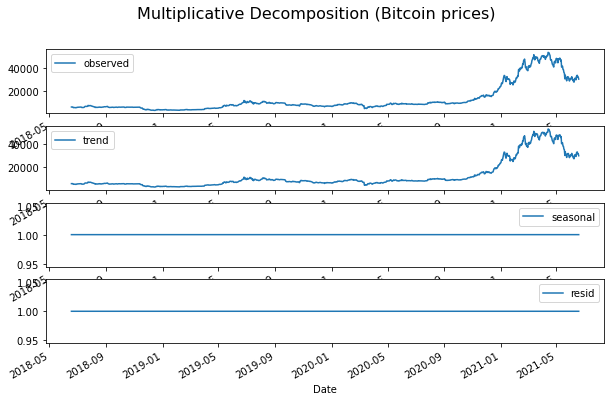

In [17]:
decomposition_btc = seasonal_decompose(df1.btc, freq=1, model='multiplicative')

fig, ax = plt.subplots(4, 1, figsize=(10,6))
decomposition_btc.observed.plot(ax=ax[0])
ax[0].legend(['observed'])
decomposition_btc.trend.plot(ax=ax[1])
ax[1].legend(['trend'])
decomposition_btc.seasonal.plot(ax=ax[2])
ax[2].legend(['seasonal'])
decomposition_btc.resid.plot(ax=ax[3])
ax[3].legend(['resid'])
plt.suptitle('Multiplicative Decomposition (Bitcoin prices)', fontsize=16)
plt.show()

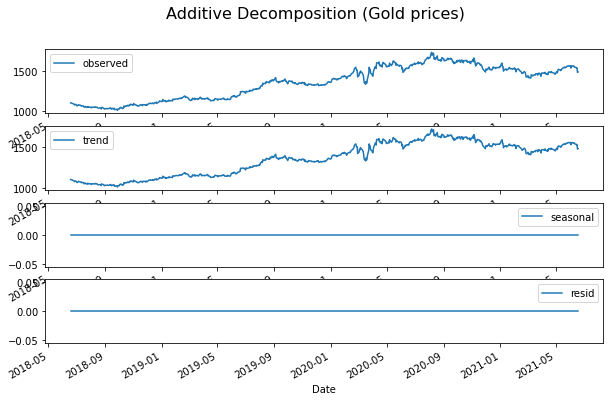

In [18]:
decomposition_g = seasonal_decompose(df2.gold, freq=1, model='additive')

fig, ax = plt.subplots(4, 1, figsize=(10,6))
decomposition_g.observed.plot(ax=ax[0])
ax[0].legend(['observed'])
decomposition_g.trend.plot(ax=ax[1])
ax[1].legend(['trend'])
decomposition_g.seasonal.plot(ax=ax[2])
ax[2].legend(['seasonal'])
decomposition_g.resid.plot(ax=ax[3])
ax[3].legend(['resid'])
plt.suptitle('Additive Decomposition (Gold prices)', fontsize=16)
plt.show()

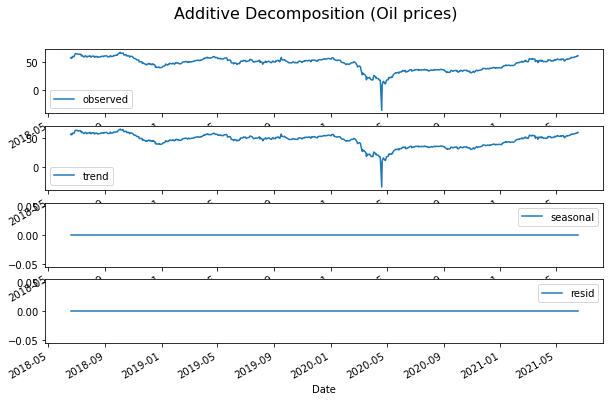

In [19]:
decomposition_o = seasonal_decompose(df3.oil, freq=1, model='additive')

fig, ax = plt.subplots(4, 1, figsize=(10,6))
decomposition_o.observed.plot(ax=ax[0])
ax[0].legend(['observed'])
decomposition_o.trend.plot(ax=ax[1])
ax[1].legend(['trend'])
decomposition_o.seasonal.plot(ax=ax[2])
ax[2].legend(['seasonal'])
decomposition_o.resid.plot(ax=ax[3])
ax[3].legend(['resid'])
plt.suptitle('Additive Decomposition (Oil prices)', fontsize=16)
plt.show()

Overall, the decomposition of each series shows that there is no sign of seasonality components in the data, and the trend component has the same pattern as the observed data in each of the series.

### Evaluate Stationarity of Prices

To evaluate the stationarity of a series, ACF plots and augmented Dickey Fuller test will be used.

##### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) Examination

In this part correlograms are use to interpret the presence of autocorrelation of a set of 40 lags.

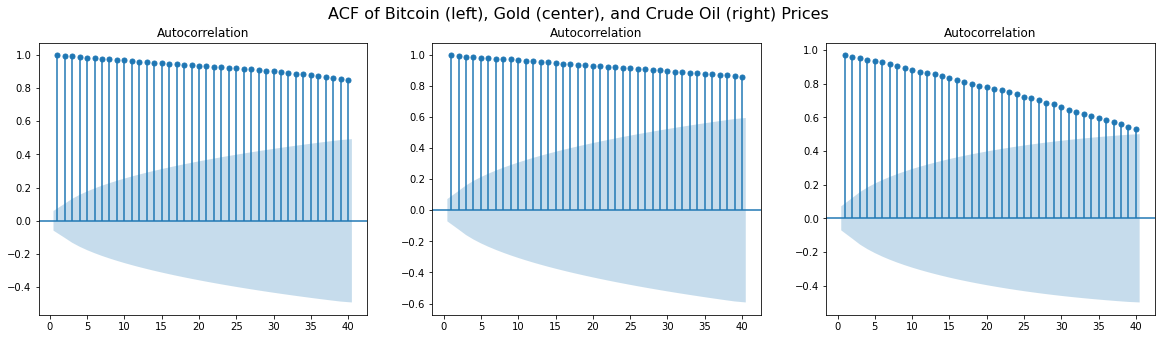

In [20]:
# ACF
fig, ax = plt.subplots(1, 3, figsize=(20,5))
# Omit the lag 0
sgt.plot_acf(df1.btc, lags=40, zero=False, ax=ax[0])
sgt.plot_acf(df2.gold, lags=40, zero=False, ax=ax[1])
sgt.plot_acf(df3.oil, lags=40, zero=False, ax=ax[2])
fig.suptitle('ACF of Bitcoin (left), Gold (center), and Crude Oil (right) Prices', fontsize=16)
plt.show()

- The patterns of all ACF plots show a sign that the price series of Bitcoin, Gold and Crude oil are non-stationary since all lags are significant (lie outside of blue areas) and gradually decrease.
- The non-oscillation (at the same frequency) in ACF and PACF plots again confirm that there are no seasonal components in each series.

#####  Augmented Dickey-Fuller test (ADF test)

In [21]:
sts.adfuller(df1.btc)

(-0.5631720631465059,
 0.8790884051561754,
 21,
 1071,
 {'1%': -3.436470487817901,
  '5%': -2.8642424166404,
  '10%': -2.5682088634756735},
 17166.64766861852)

In [22]:
sts.adfuller(df2.gold)

(-1.3205091636873036,
 0.6197379000179286,
 19,
 729,
 {'1%': -3.4393520240470554,
  '5%': -2.8655128165959236,
  '10%': -2.5688855736949163},
 6065.608272490675)

In [23]:
sts.adfuller(df3.oil)

(-1.5350164804967885,
 0.5161235921868943,
 4,
 744,
 {'1%': -3.4391698996357687,
  '5%': -2.8654325580580204,
  '10%': -2.568842816582842},
 3418.122151487645)

The Augmented Dickey Fuller test indicates that p-values are 0.879, 0.619 and 0.516 respectively for Bitcoin, Gold and Crude oil price series, which are much larger than the 5% level, so the null hypothesis cannot be rejected. Therefore, we conclude that these series are non-stationary.

### Working on Returns

- Since the prices of each commodity (Bitcoin, Gold and Crude oil) are highly volatile and non-stationary, models to fit the data are hard to find. Instead of prices, we will work on returns because the series have the properties examined as below. Additionally, analysing returns is more meaningful since it is the gain or loss that investors care about. 
- Log returns $r_t$ are used and defined as the log of the ratio of the price at time $t$ to the price of the previous period $t-1$:

$$r_t = log(P_t/P_{t-1})$$

In [24]:
# Convert prices to returns
# for Bitcoin
df1['log_ret_btc'] = np.log(df1.btc/df1.btc.shift(1))
# for Gold
df2['log_ret_g'] = np.log(df2.gold/df2.gold.shift(1))
# For Crude oil series contain negative values, so we will transfrom it before taking the log
df3['trans_o'] = df3['oil'] + 1 - df3['oil'].min()
df3['log_ret_o'] = np.log(df3.trans_o/df3.trans_o.shift(1))

In [25]:
# Compare the original Crude oil price series and the transformed series trans_o
# fig, ax = plt.subplots(1, 2, figsize=(15,5))
# df3.oil.plot(ax=ax[0])

In [26]:
# Check the missing values of the series
print('Number of missing values of Bitcoin log returns:', df1.log_ret_btc.isna().sum())
print('Number of missing values of Gold log returns:', df2.log_ret_g.isna().sum())
print('Number of missing values of Crude oil log returns:', df3.log_ret_o.isna().sum())

Number of missing values of Bitcoin log returns: 1
Number of missing values of Gold log returns: 1
Number of missing values of Crude oil log returns: 1


The missing values is the first value in each series, caused by the above transformation.

In [27]:
# For example
df1.log_ret_btc.head()

Date
2018-06-18         NaN
2018-06-19    0.002205
2018-06-20    0.004610
2018-06-21   -0.006109
2018-06-22   -0.103232
Name: log_ret_btc, dtype: float64

##### Descriptive Statistics of Log Returns

###### Time plots of log returns

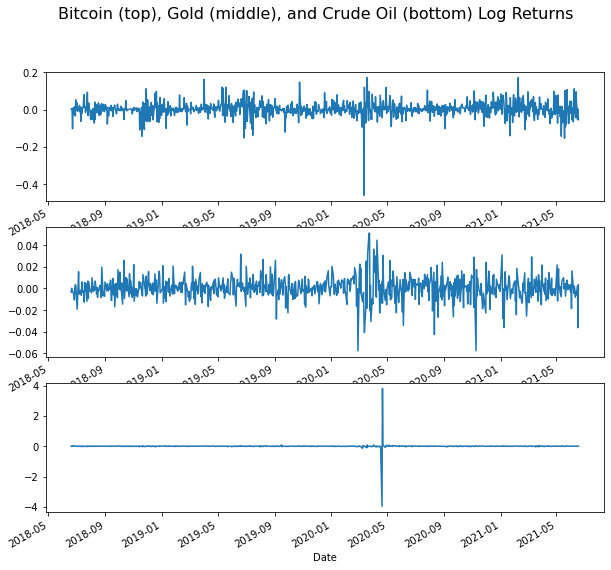

In [28]:
# Plot 3 series of log returns
fig, ax = plt.subplots(3, 1, figsize=(10,9))
df1.log_ret_btc.plot(ax=ax[0])
df2.log_ret_g.plot(ax=ax[1])
df3.log_ret_o.plot(ax=ax[2])
fig.suptitle('Bitcoin (top), Gold (middle), and Crude Oil (bottom) Log Returns', fontsize=16)
plt.show()

The plots of the Bitcoin, Gold and Crude Oil log returns all shows the volatility fluctuate around a mean of zero. Additionally, we can notice some sudden changes in these time series in around May 2020, which can be explained by the events mentioned when we observe the prices of each commodities. 

###### Distributions of the log returns series

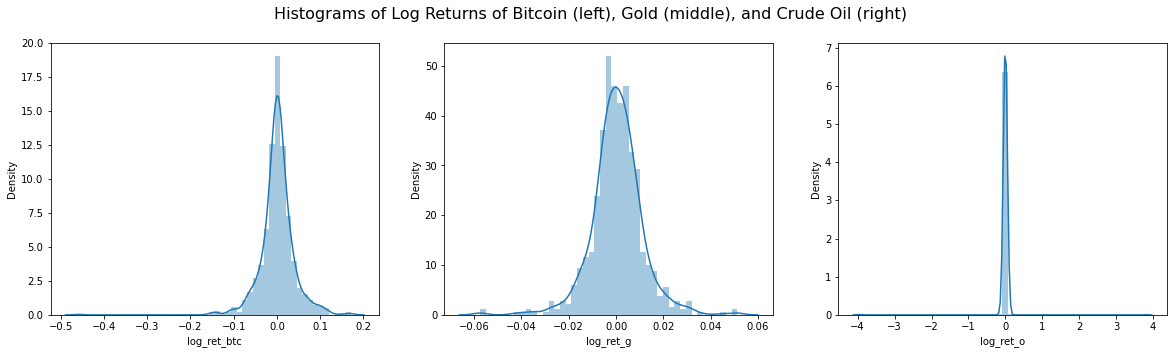

In [29]:
# Check the distribution of each series by histograms
fig, ax = plt.subplots(1, 3, figsize=(20,5))
sns.distplot(df1.log_ret_btc[1:], ax=ax[0]) 
sns.distplot(df2.log_ret_g[1:], ax=ax[1]) 
sns.distplot(df3.log_ret_o[1:], ax=ax[2])
fig.suptitle('Histograms of Log Returns of Bitcoin (left), Gold (middle), and Crude Oil (right)', fontsize=16)
plt.show()

In [30]:
# Check the mean, skewness and kurtosis
print('- Bitcoin log returns:')
print('Mean:', df1.log_ret_btc.mean()) 
print('Skewness:', df1.log_ret_btc[1:].skew())
print('Kurtosis:', df1.log_ret_btc[1:].kurtosis()) 
print('\n')
print('- Gold log returns:')
print('Mean:', df2.log_ret_g.mean())
print('Skewness:', df2.log_ret_g[1:].skew())
print('Kurtosis:', df2.log_ret_g[1:].kurtosis())
print('\n')
print('- Crude oil log returns:', df3.log_ret_o.mean())
print('Skewness:', df3.log_ret_o[1:].skew())
print('Kurtosis:', df3.log_ret_o[1:].kurtosis())

- Bitcoin log returns:
Mean: 0.001504845637430175
Skewness: -1.3671398794923966
Kurtosis: 19.046134389713917


- Gold log returns:
Mean: 0.00039959419652422313
Skewness: -0.1808071154681747
Kurtosis: 4.383718948888667


- Crude oil log returns: 4.756000625377084e-05
Skewness: -1.1629069078443166
Kurtosis: 369.0667387017732


Combine the histograms and the calculation above, we can see that:
- The mean of each series is close to zero. Precisely, the mean of returns are positive, also imply that the prices increased over the period in general. 
- The data of Bitcoin and Crude oil are left-skewed with heavy tails. Only Gold log return data is symmetric in its distribution.
- Among the 3 series, Crude oil log returns has the highest kurtosis. This also implies that there are extreme values in the data, align with the observation from the original prices of Crude oil. 
- In addition, the kurtosis of Bitcoin log returns are also high (compared to the kurtosis of normal distribution is 3). We may say that the Crude oil and Bitcoin returns comes with high risk for investors.

In conclusion, it is evident that distribution of 3 series are not normal distributed.

##### Stationarity Evaluation of Returns

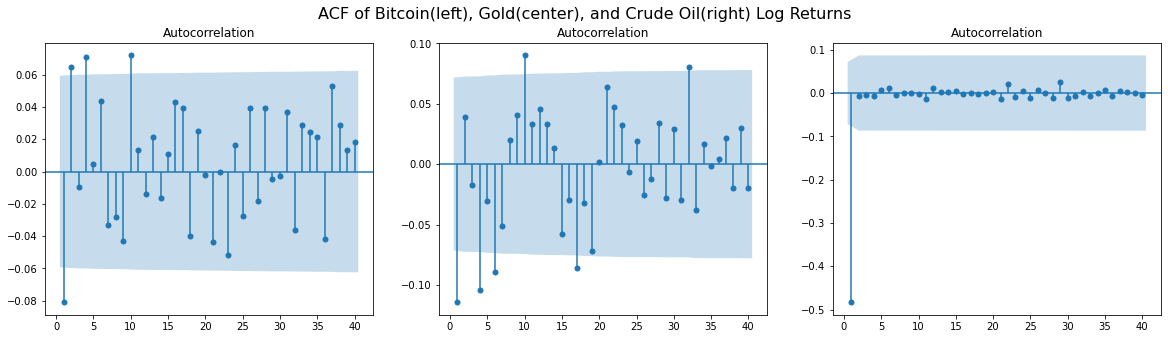

In [31]:
# ACF
fig, ax = plt.subplots(1, 3, figsize=(20,5))
# Omit the lag 0
sgt.plot_acf(df1.log_ret_btc[1:], lags=40, zero=False, ax=ax[0])
sgt.plot_acf(df2.log_ret_g[1:], lags=40, zero=False, ax=ax[1])
sgt.plot_acf(df3.log_ret_o[1:], lags=40, zero=False, ax=ax[2])
fig.suptitle('ACF of Bitcoin(left), Gold(center), and Crude Oil(right) Log Returns', fontsize=16)
plt.show()

As can be seen from plots, the Bitcoin, Gold and Crude oil log returns have ACF cut off after a few lags (no exponential decay) and most of lags are within the 95% confidence limits. 

In [32]:
# ADF test
sts.adfuller(df1.log_ret_btc[1:])

(-15.252117910392501,
 4.992682524476297e-28,
 3,
 1088,
 {'1%': -3.4363746281360426,
  '5%': -2.864200133611212,
  '10%': -2.568186343567528},
 -3877.3171975219293)

In [33]:
sts.adfuller(df2.log_ret_g[1:])

(-13.278488419922722,
 7.778174748184684e-25,
 6,
 741,
 {'1%': -3.4392057325732104,
  '5%': -2.8654483492874236,
  '10%': -2.5688512291811225},
 -4521.731858979765)

In [34]:
sts.adfuller(df3.log_ret_o[1:])

(-11.77910341465196,
 1.0451841666632976e-21,
 11,
 736,
 {'1%': -3.4392661055744767,
  '5%': -2.86547495466493,
  '10%': -2.56886540295664},
 -600.6176354137001)

- The test shows that p-value of Bitcoin, Gold and Crude oil lof returns are 4.99e-28, 7.77e-25 and 1.04e-21, whcih is much lower than the significant level of 5%. Hence, the null hypothesis can be rejected, and we can conclude that the each series is stationary.
- Since the series are stationary, the next step of modelling using ARIMA can be carried out.

## Model Selection

### Bitcoin Log Returns

#### Model Identifycation 

#####  ACF and PACF examination

- The model specification initially relies on the autocorrelation and partial autocorrelation function (ACF, PACF).
- Because the value at lag 0 always show a perfect correlation (the correlation between today’s value with itself), we only care from the lag 1.

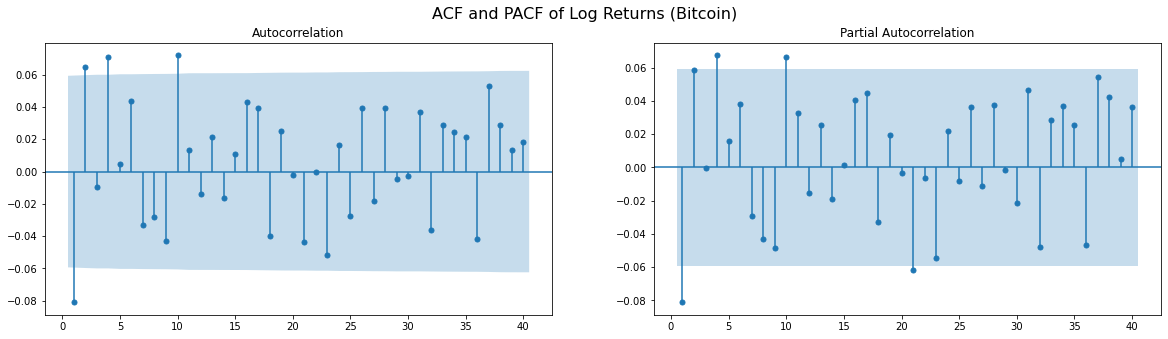

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# Omit the lag 0
sgt.plot_acf(df1.log_ret_btc[1:], lags=40, zero=False, ax=ax[0]) 
sgt.plot_pacf(df1.log_ret_btc[1:], lags=40, zero=False, method=('ols'), ax=ax[1])
fig.suptitle('ACF and PACF of Log Returns (Bitcoin)', fontsize=16)
plt.show()

- ACF plot shows that the lags 1, 2, 4, 10 are significant.
- PACF shows that the lags at 1, 2, 4, 10 are significant.
- Because both ACF and PACF cut off after the lag 10, we consider the mixed model ARMA. The list of possible models are from ARMA(1,1) to ARMA(10,10).

##### Fitting models to check the significance of coefficients

If a model has all coefficients insignificant, it cannot be used for forecasting. After the possible model are tested, the candidates with statistically significant coefficients are ARMA(1,1), ARMA(2,2), ARMA(2,1)

In [36]:
# Fitting the possible models
model_btc_arma1= ARMA(df1.log_ret_btc[1:], order = (1,1))
model_btc_arma2= ARMA(df1.log_ret_btc[1:], order = (2,2))
model_btc_arma3= ARMA(df1.log_ret_btc[1:], order = (2,1))

results_btc_arma1=model_btc_arma1.fit()
results_btc_arma2=model_btc_arma2.fit()
results_btc_arma3=model_btc_arma3.fit()

In [37]:
print(results_btc_arma1.summary())

                              ARMA Model Results                              
Dep. Variable:            log_ret_btc   No. Observations:                 1092
Model:                     ARMA(1, 1)   Log Likelihood                1988.220
Method:                       css-mle   S.D. of innovations              0.039
Date:                Fri, 09 Jul 2021   AIC                          -3968.441
Time:                        00:32:11   BIC                          -3948.458
Sample:                             0   HQIC                         -3960.878
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0015      0.001      1.321      0.186      -0.001       0.004
ar.L1.log_ret_btc    -0.7829      0.130     -6.005      0.000      -1.038      -0.527
ma.L1.log_ret_btc     0.

In [38]:
print(results_btc_arma2.summary())

                              ARMA Model Results                              
Dep. Variable:            log_ret_btc   No. Observations:                 1092
Model:                     ARMA(2, 2)   Log Likelihood                1989.263
Method:                       css-mle   S.D. of innovations              0.039
Date:                Fri, 09 Jul 2021   AIC                          -3966.526
Time:                        00:32:11   BIC                          -3936.551
Sample:                             0   HQIC                         -3955.182
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0014      0.002      0.900      0.368      -0.002       0.005
ar.L1.log_ret_btc     0.2146      0.150      1.429      0.153      -0.080       0.509
ar.L2.log_ret_btc     0.

In [39]:
print(results_btc_arma3.summary())

                              ARMA Model Results                              
Dep. Variable:            log_ret_btc   No. Observations:                 1092
Model:                     ARMA(2, 1)   Log Likelihood                1988.082
Method:                       css-mle   S.D. of innovations              0.039
Date:                Fri, 09 Jul 2021   AIC                          -3966.165
Time:                        00:32:11   BIC                          -3941.186
Sample:                             0   HQIC                         -3956.712
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0015      0.001      1.165      0.244      -0.001       0.004
ar.L1.log_ret_btc     0.5770      0.230      2.504      0.012       0.125       1.029
ar.L2.log_ret_btc     0.

##### Filtering models based on AIC

In [40]:
print("ARMA(1,1)", '- AIC:', results_btc_arma1.aic, ', BIC:', results_btc_arma1.bic)
print("ARMA(2,2)", '- AIC:', results_btc_arma2.aic, ', BIC:', results_btc_arma2.bic)
print("ARMA(2,1)", '- AIC:', results_btc_arma3.aic, ', BIC:', results_btc_arma3.bic)

ARMA(1,1) - AIC: -3968.4405908183685 , BIC: -3948.457526193149
ARMA(2,2) - AIC: -3966.5256290860984 , BIC: -3936.5510321482693
ARMA(2,1) - AIC: -3966.164673096889 , BIC: -3941.185842315365


Based on the information criteria, the model has the lowest AIC and BIC is ARMA(1,1), or ARIMA(1,0,1). In the next step we will check the adequacy of the fitted model by the residuals diagnosis.

#### Model Estimation

In [41]:
model_btc_arima = ARIMA(df1.log_ret_btc[1:], order=(1,0,1))
results_btc_arima = model_btc_arima.fit(nethod='mle')
print(results_btc_arima.summary())

                              ARMA Model Results                              
Dep. Variable:            log_ret_btc   No. Observations:                 1092
Model:                     ARMA(1, 1)   Log Likelihood                1988.220
Method:                       css-mle   S.D. of innovations              0.039
Date:                Fri, 09 Jul 2021   AIC                          -3968.441
Time:                        00:32:12   BIC                          -3948.458
Sample:                             0   HQIC                         -3960.878
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0015      0.001      1.321      0.186      -0.001       0.004
ar.L1.log_ret_btc    -0.7829      0.130     -6.005      0.000      -1.038      -0.527
ma.L1.log_ret_btc     0.

Model equation of ARMA(1,1):
$$ X_t = α.X_{t−1} + Z_t + β.Z_{t−1}$$


$$X_t = 0.0015 - 0.7829.X_{t-1} + Z_t + 0.7152.Z_t$$

#### Residual Diagnostics

In [42]:
# create residual series
df1['res_btc'] = results_btc_arima.resid

- We check the residuals to see if a model can capture all information to generate a good forecasting results. The expected result is that residuals ressemble white noise. The conditions that residual should satisfied are: (1) no autocorrelation, (2) constant variance, and (3) normal distribution.

- Autocorrelation can be tested via correlogram of the residuals and Ljung-Box test, variance of the series can be examined by the plot of the residuals and the distribution can be checked with the histogram and QQplot. The Engle's ARCH Test is to examine the presence of conditional variance in the model.

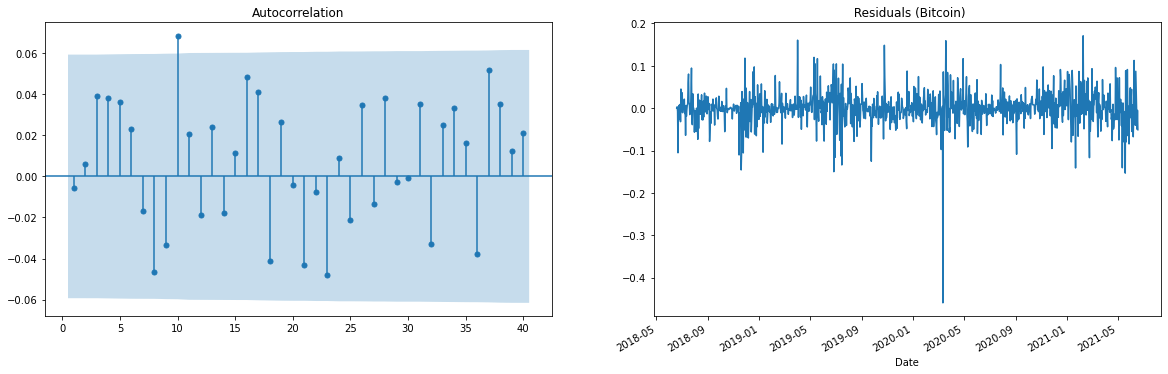

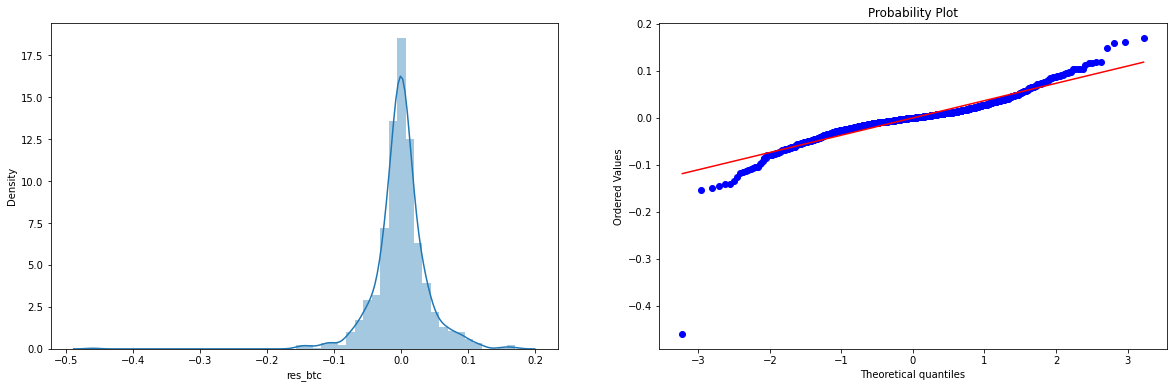

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
# ACF of the residuals
sgt.plot_acf(df1.res_btc[1:], lags=40, zero=False, ax=ax[0])
# Plot the residuals
df1.res_btc.plot(title=" Residuals (Bitcoin)", ax=ax[1])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,6))
# Histogram of the estimated residuals
sns.distplot(df1.res_btc[1:], ax=ax[0]) 
# QQ-plot of the estimated residuals
scipy.stats.probplot(df1.res_btc[1:], plot=pylab)
pylab.show()

In [44]:
# Check the mean of the residual
print('Mean of the residuals (Bitcoin):', df1.res_btc[1:].mean())

Mean of the residuals (Bitcoin): 1.4760493922712438e-06


In [45]:
# Shapiro-Wilks test
stats.shapiro(df1.res_btc[1:])

ShapiroResult(statistic=0.8803409337997437, pvalue=3.5165186520464675e-28)

In [46]:
# ARCH test on the squared residuals
het_arch(df1.res_btc[1:]**2, ddof=2)

(0.21467090240217912, 1.0, 0.009567825219435392, 0.9999999999999999)

In [47]:
# Ljung-Box test
acorr_ljungbox(df1.res_btc[1:], lags=[30], return_df=True) 

,lb_stat,lb_pvalue
30,32.17092,0.359621


##### Residual examination results:
- Autocorrelation: ACF shows 1 significant lag suggesting the residual have the autocorrelation, but the p-value=0.35 of Ljung-Box test confirms that residual series is not autocorrelated. It is possible that arbitrary lag is totally random while the series still random. We can conclude that the residuals have no autocorrelation. (Source: Chris Chatfield Haipeng Xing.The Analysis of Time Series An Introduction with R)

- Normal distribution: The mean of the residuals are (almost) zero, which is confirmed by the calculation and the histogram. Shapiro-Wilk normality test shows the p-value=3.51e-28 is smaller than the significant level of 0.05, null hypothesis of normality is rejected. Additionally, the histogram shows the fat tails, but there is the symmetry in the data. QQ plot also shows the same result of non-normal distribution of the residuals.

- Variance: ARCH test indicates that pvalue=1.0 is larger than the significant level of 0.05, We do not have enough evidence to reject the null hypothesis at 5% and conclude no presence of ARCH effects. This also mean that the model is adequate for the use of forecasting.


Conclusion: The most important properties that the residuals of the model ARIMA(1,0,1) satisfied is the independent and identically distribution, meaning that forecasts from this method will be good enough. However, it is not normal distributed, which leads to the inaccuracy of prediction intervals under the assumption of a normal distribution.

### Gold Log Returns

#### Model Identification

##### ACF and PACF examination

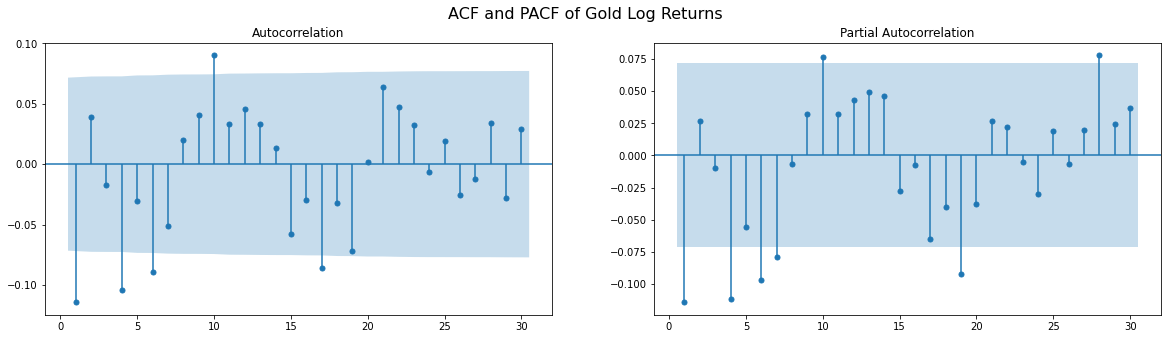

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# Omit the lag 0 
sgt.plot_acf(df2['log_ret_g'][1:], lags=30, zero=False, ax=ax[0])
sgt.plot_pacf(df2['log_ret_g'][1:], lags=30, zero=False, method=('ols'), ax=ax[1])
fig.suptitle('ACF and PACF of Gold Log Returns', fontsize=16)
plt.show()

- ACF plot shows that the lags  1, 4, 6 are significant.
- PACF shows that the lags at 1, 4, 6, 7 are significant.
- Because the patterns shows the lags cut off after the lag 6, we consider the model ARMA. The list of possible models are from ARMA(1,1) to ARMA(7,6).

#### Model Estimation

Among 12 listed models, the possible candidate with singificant coeffients at significant level of 5% are ARMA(4,1) and ARMA(6,7).

In [49]:
# Fitting the possible models
model_g_arma1= ARMA(df2.log_ret_g[1:], order = (4,1))
model_g_arma2= ARMA(df2.log_ret_g[1:], order = (6,1))
model_g_arma3= ARMA(df2.log_ret_g[1:], order = (7,6))
results_g_arma1=model_g_arma1.fit()
results_g_arma2=model_g_arma2.fit()
results_g_arma3=model_g_arma3.fit()

In [50]:
print(results_g_arma1.summary())

                              ARMA Model Results                              
Dep. Variable:              log_ret_g   No. Observations:                  748
Model:                     ARMA(4, 1)   Log Likelihood                2336.457
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 09 Jul 2021   AIC                          -4658.915
Time:                        00:33:34   BIC                          -4626.593
Sample:                             0   HQIC                         -4646.459
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000      1.578      0.115      -0.000       0.001
ar.L1.log_ret_g     0.4787      0.110      4.371      0.000       0.264       0.693
ar.L2.log_ret_g     0.0934      

In [51]:
print(results_g_arma2.summary())

                              ARMA Model Results                              
Dep. Variable:              log_ret_g   No. Observations:                  748
Model:                     ARMA(6, 1)   Log Likelihood                2338.587
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 09 Jul 2021   AIC                          -4659.175
Time:                        00:33:35   BIC                          -4617.618
Sample:                             0   HQIC                         -4643.160
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000      1.637      0.102    -8.3e-05       0.001
ar.L1.log_ret_g     0.2331      0.170      1.368      0.171      -0.101       0.567
ar.L2.log_ret_g     0.0557      

In [52]:
print(results_g_arma3.summary())

                              ARMA Model Results                              
Dep. Variable:              log_ret_g   No. Observations:                  748
Model:                     ARMA(7, 6)   Log Likelihood                2350.396
Method:                       css-mle   S.D. of innovations              0.010
Date:                Fri, 09 Jul 2021   AIC                          -4670.791
Time:                        00:33:35   BIC                          -4601.530
Sample:                             0   HQIC                         -4644.100
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000      1.470      0.141      -0.000       0.001
ar.L1.log_ret_g    -0.5261      0.094     -5.611      0.000      -0.710      -0.342
ar.L2.log_ret_g     0.1191      

##### Filtering models based on AIC

In [53]:
print("ARMA(4,1)", '- AIC:', results_g_arma1.aic, ', BIC:', results_g_arma1.bic)
print("ARMA(6,1)", '- AIC:', results_g_arma2.aic, ', BIC:', results_g_arma2.bic)
print("ARMA(7,6)", '- AIC:', results_g_arma3.aic, ', BIC:', results_g_arma3.bic)

ARMA(4,1) - AIC: -4658.914733094605 , BIC: -4626.592912248784
ARMA(6,1) - AIC: -4659.174989092442 , BIC: -4617.618362290672
ARMA(7,6) - AIC: -4670.79118874318 , BIC: -4601.530144073563


Based on AIC, the better model is ARMA(6,7) for the Gold log returns series. Meanwhile, if we choose the BIC criteria, ARMA(4,1) has the lowest BIC. We continue testing the validity of the models via residuals to see which one is the best fit model.

#### Model estimation

After fitting, the residuals of ARMA(4,1) does not pass the test of autocorrelation, so the only candidate is ARMA(7,6).

In [54]:
model_g_arima = ARIMA(df2.log_ret_g[1:], order=(7,0,6))
results_g_arima = model_g_arima.fit()
print(results_g_arima.summary())

                              ARMA Model Results                              
Dep. Variable:              log_ret_g   No. Observations:                  748
Model:                     ARMA(7, 6)   Log Likelihood                2350.396
Method:                       css-mle   S.D. of innovations              0.010
Date:                Fri, 09 Jul 2021   AIC                          -4670.791
Time:                        00:34:55   BIC                          -4601.530
Sample:                             0   HQIC                         -4644.100
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000      1.470      0.141      -0.000       0.001
ar.L1.log_ret_g    -0.5261      0.094     -5.611      0.000      -0.710      -0.342
ar.L2.log_ret_g     0.1191      

#### Residual Diagnostics

In [55]:
# create residual series
df2['res_g'] = results_g_arima.resid

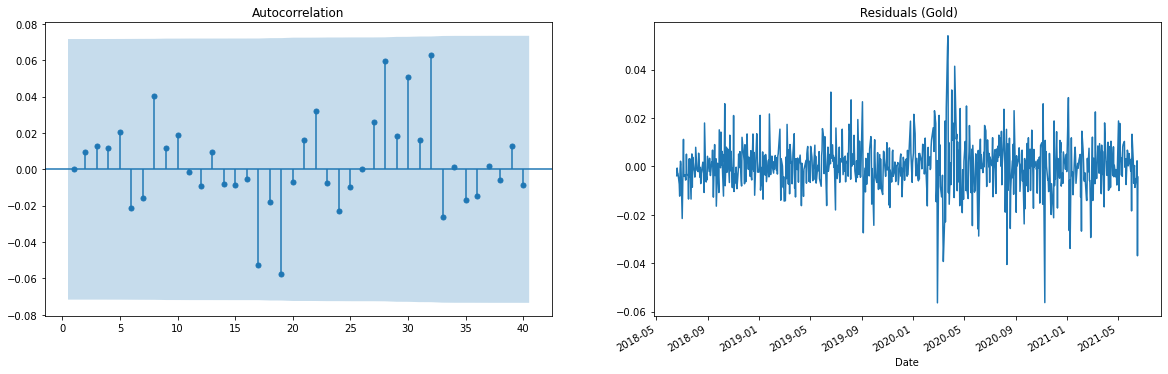

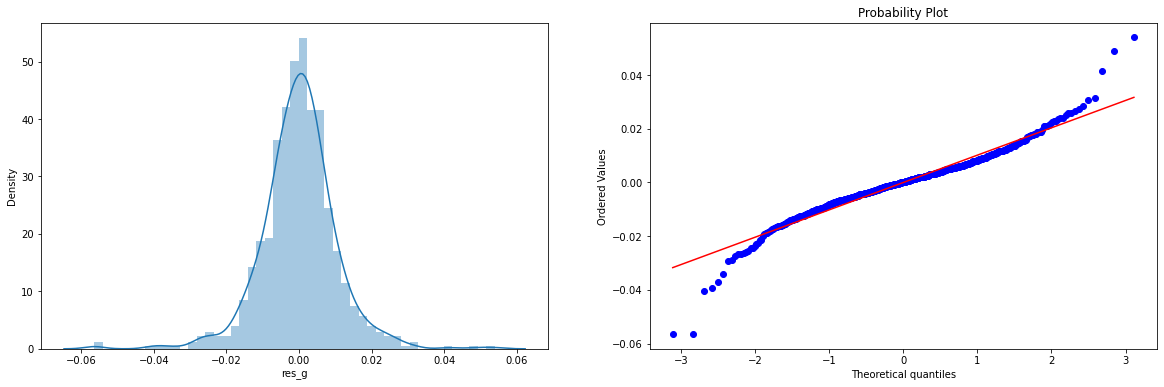

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
# ACF
sgt.plot_acf(df2.res_g[1:], lags=40, zero=False, ax=ax[0])
# Plot the residuals
df2.res_g.plot(title=" Residuals (Gold)", ax=ax[1])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,6))
# Histogram of the estimated residuals
sns.distplot(df2.res_g[1:], ax=ax[0]) 
# QQ-plot of the estimated residuals
scipy.stats.probplot(df2.res_g[1:], plot=pylab)
pylab.show()

In [57]:
# Check the mean of residuals
df2.res_g[1:].mean()

-1.233673288427685e-05

In [58]:
# ARCH test on the squared residuals
het_arch(df2.res_g[1:]**2, ddof=13)

(76.15457420752085,
 1.7472211213500475e-08,
 4.2139523733716855,
 3.07565726711543e-09)

In [59]:
# Shapiro-Wilks test
stats.shapiro(df2.res_g[1:])

ShapiroResult(statistic=0.9471506476402283, pvalue=1.0700973798478258e-15)

In [60]:
# Ljung-Box test
acorr_ljungbox(df2.res_g[1:], lags=[30], return_df=True) 

,lb_stat,lb_pvalue
30,15.052444,0.98944


Residual examination results:

- Autocorrelation: ACF shows no significant lags, recommends that residual series is uncorrelated. P-value=0.97 of Ljung-Box test indicates that we do not have enough statistical evidence to reject the null hypothesis, meaning that there is no autocorrelation in the residuals. 
- Variance: ARCH test indicates that pvalue=7.69e-10 is smaller than the significant level of 5%, the null hypothesis is accepted with the presence of ARCH effects. This suggests that the model ARMA(6,7) needed a modification. The model can be used to account for the volatility of the residuals is GARCH.
- Normal distribution: The mean of the residuals are close to zero, which is confirmed by the calculation and the histogram. Shapiro-Wilk normality test shows the p-value=2.29e-15 is smaller than the significant level of 0.05, so the null hypothesis of normality is rejected. Additionally, the histogram shows the fat tails, but there is the symmetry in the data. QQ plot also shows the same result of non-normal distribution of the residuals.

#### GARCH Model on Residuals 

##### PACF of the squared residuals

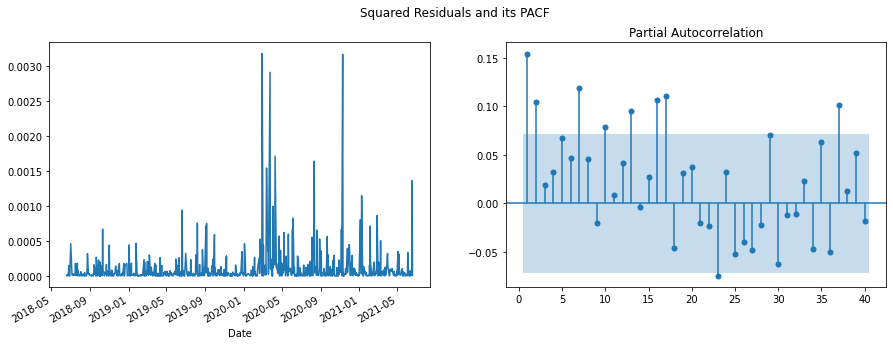

In [61]:
df2['sqrt_res_g'] = df2.res_g**2
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle('Squared Residuals and its PACF')
df2.sqrt_res_g.plot(ax=ax[0])

sgt.plot_pacf(df2.sqrt_res_g[1:], lags=40, zero=False, ax=ax[1])
plt.show()

The plot of the squared residuals indicates that the periods of low volatility followed by the periods of low volatility, and the periods of high volatility followed by the periods of high volatility. Meanwhile, The PACF of the squared residuals presents that there is the autocorrelation in the series, which also confirms the presence of the volatility clustering.

##### GARCH model estimation

In [62]:
model_g_garch = arch_model(df2.res_g[1:], vol='GARCH', p=1, q=1)
result_g_garch = model_g_garch.fit()
result_g_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 665673192.7335607
Iteration:      2,   Func. Count:     18,   Neg. LLF: 613574.6022598911
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1740469825069.951
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2393.1687542646614
            Iterations: 4
            Function evaluations: 39
            Gradient evaluations: 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  res_g   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2393.17
Distribution:                  Normal   AIC:                          -4778.34
Method:            Maximum Likelihood   BIC:                          -4759.87
                                        No. Observations:                  748
Date:                Fri, Jul 09 2021   Df Residuals:                      747
Time:                        00:35:04   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.5753e-04  1.579e-04     -0.998      0.318 [-4.670e-04,1.519e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1815e-06  1.508e-11  1.446e+05      0.000 [2.181e-06,2.181e-06]
alpha[1]       0.0500  2.573e-02      1.944  5.194e-02  [-4.211e-04,  0.100]
beta[1]        0.9300  2.195e-02     42.363      0.000     [  0.887,  0.973]
============================================================================

Covariance estimator: robust
"""

GACRH(1,1) of the residuals shows that all the coefficients are significant at the significant level of 5%. Additionally, $\alpha + \beta = 0.93+0.05 < 1$, indicating that model is stable.

The model ARMA(7,6)-GARCH(1,1) above seems to be good. However, the prefer way is fitting the ARMA-GARCH at the same time to ensure the consistence in the results. Because there are no libraries available for fitting ARMA-GARCH simultaneously in Python, I use R language to check if the model is valid with the ARCH test on the residual as below:

Coefficients of the mean and variance models: all are statistical significant since p-values are smaller than 0.05. In addition, $\alpha + \beta = 0.071 + 0.927 < 1$ so the model is stable.
Residual diagnostics: 
- Weighted Ljung-Box Test on Standardized Squared Residuals: p-values are 0.148, 0.556 and 0.818 which are larger than 5% level, so we cannot reject the null hypothesis, meaning that there is no serial correlation in the residuals of the model.
- Weighted ARCH LM Tests: p-values are 0.847, 0.911 and 0.97 which are larger than 5% level, meaning that there is no evidence of ARCH effect in the residuals of the model.
 
These tests confirm that the residuals resemble white noises, so the model is adequate for the purpose of forecasting.

- Model equation of ARMA(7,6)-GARCH(1,1):

$ r_t = 0.003002 - 0.817318X_{t-1} - 0.921419X_{t-2} - 0.852645X_{t-3} - 0.662510X_{t-4} - 0.728112X_{t-5} + 0.188247X_{t-6} + 0.046610X_{t-7}  + Y_t + 0.389016Y_{t-1} + 0.609857Y_{t-2} + 0.455669Y_{t-3} + 0.265927Y_{t-4} + 0.399217Y_{t-5} - 0.612433Y_{t-6}$


$ Y_t =  \sigma_t\epsilon_t$


$\sigma_t^2 = 0.000035 + 0.071207Y_{t-1}^2 + 0.927793\sigma_{t-1}^2$

### Crude Oil Log Returns

#### Model Identification

##### ACF and PACF Examination

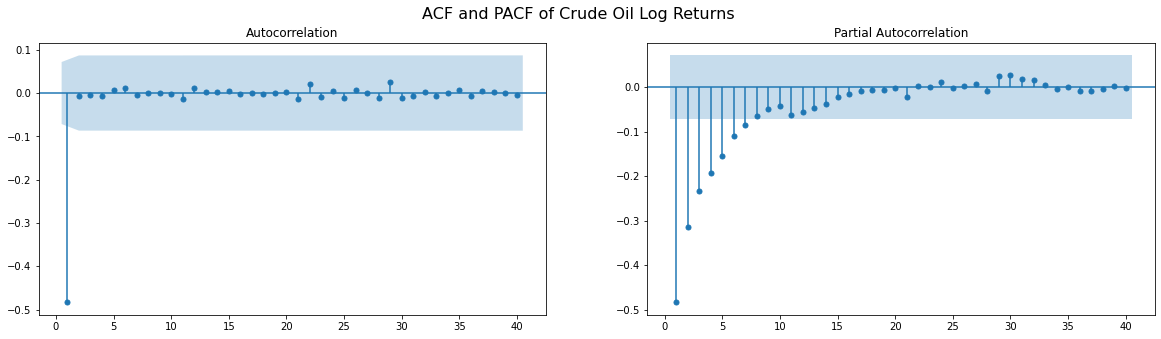

In [63]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sgt.plot_acf(df3.log_ret_o[1:], zero=False, lags=40, ax=ax[0])
sgt.plot_pacf(df3.log_ret_o[1:], lags=40, zero=False, method=('ols'), ax=ax[1])
fig.suptitle('ACF and PACF of Crude Oil Log Returns', fontsize=16)
plt.show()

- While the ACF cuts off right after lag 1, the PACF shows the gradual decrease. This suggest that the suitable model can be MA(1), ot ARIMA(0,0,1).

#### Model Estimation

In [64]:
model_o_arima = ARIMA(df3.log_ret_o[1:], order=(0,0,1))
results_o_arima = model_o_arima.fit()
print(results_o_arima.summary())

                              ARMA Model Results                              
Dep. Variable:              log_ret_o   No. Observations:                  748
Model:                     ARMA(0, 1)   Log Likelihood                 332.823
Method:                       css-mle   S.D. of innovations              0.155
Date:                Fri, 09 Jul 2021   AIC                           -659.647
Time:                        00:35:05   BIC                           -645.794
Sample:                             0   HQIC                          -654.308
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -6.945e-06      0.001     -0.008      0.994      -0.002       0.002
ma.L1.log_ret_o    -0.8393      0.020    -42.637      0.000      -0.878      -0.801
                                

The coefficient of the MA(1) is statiscally significant at 5%, so we can continue to check the residuals.

Model equation of MA(1):
$$ X_t = -6.945e^{-06} + Z_t - 0.8393Z_{t-1} $$

#### Residual Diagnostics

In [65]:
# create residual series
df3['res_o'] = results_o_arima.resid

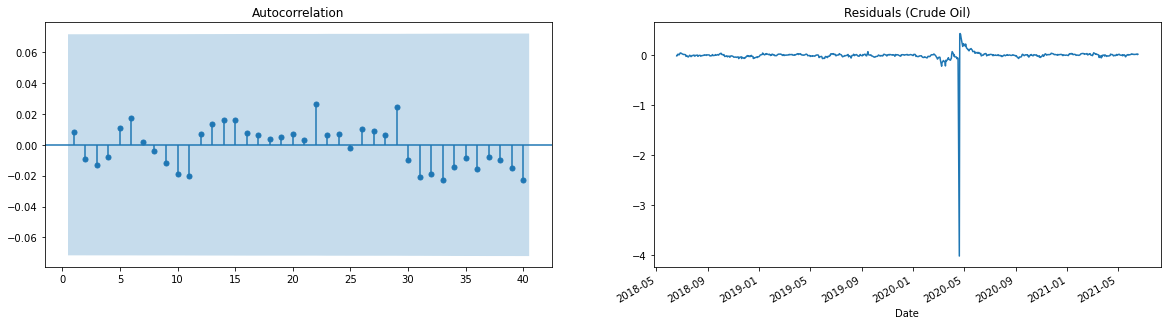

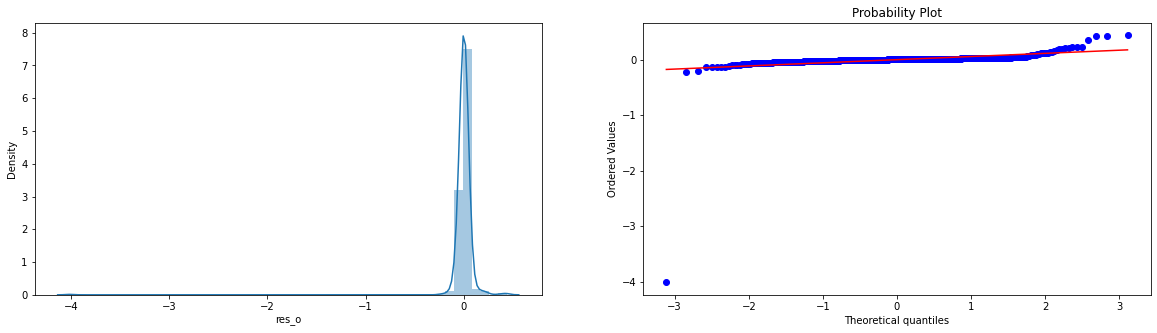

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# ACF
sgt.plot_acf(df3.res_o[1:], lags=40, zero=False, ax=ax[0])
# Plot the residuals
df3.res_o.plot(title = "Residuals (Crude Oil)", ax=ax[1])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,5))
# Histogram of the estimated residuals
sns.distplot(df3.res_o, ax=ax[0]) 
# QQ-plot of the estimated residuals
scipy.stats.probplot(df3.res_o[1:], plot=pylab)
pylab.show()

In [67]:
# Check the mean of residuals
df3.res_o[1:].mean()

0.00013545176315008965

In [68]:
# Engle’s ARCH test
het_arch(df3.res_o[1:]**2, ddof=1)

(0.02723724930545013, 1.0, 0.0013244468187565092, 0.9999999999999999)

In [69]:
# Ljung-Box test
acorr_ljungbox(df3.res_o[1:], lags=[30], return_df=True) 

,lb_stat,lb_pvalue
30,3.401527,1.0


In [70]:
# Shapiro-Wilks test
stats.shapiro(df3.res_o[1:])

ShapiroResult(statistic=0.13947975635528564, pvalue=0.0)

Residual examination results:

- Autocorrelation: ACF shows no significant lags, recommends that residual series has no autocorrelated. The same result is confirmed by the p-value=1.0 of Ljung-Box test.
- Variance: ARCH test indicates that pvalue=1.0 is larger than the significant level of 0.05, We do not have enough evidence to reject the null hypothesis at 5% and conclude that there is the absence of ARCH effects. This also mean that the model is adequate for the use of forecasting.
- Normal distribution: The mean of the residuals are nearly zero, which is confirmed by the calculation and the histogram. Shapiro-Wilk normality test shows the p-value=0 is smaller than the significant level of 5%, so null hypothesis of normality is rejected. Additionally, the histogram shows the right fat tails, showing the asymmetry in the data. QQ plot also shows the same result of non-normal distribution of the residuals with the presence of outliers.


Conclusion: The most important properties that the residuals of the model ARIMA(0,0,1) satisfied is the independent and identically distribution, meaning that forecasts from this method will be good enough. However, it is not normal distributed, which leads to the inaccuracy of prediction intervals under the assumption of a normal distribution.


## Conslusion

After analysing each series, we conclude that: 

- Bitcoin series: increasing volatility, but with high return. The best model is found relies on the significant of the coefficients and AIC is ARMA(1,1) for log return series.

- Gold series: ARMA(7,6)-GARCH(1,1) is the best fit model since it can model both the conditional mean and conditional variance of the gold log return series.

- Crude oil series: Have sudden change in the series with negative prices, which is unusual thing happens to prices. Even though we examine that there are outliers in the data, we cannot drop it because they are not the error of the data and it contains the information of the oil price movement. Removing them to achieve a better fit model is also meaningless. However, the outliers are 1 or 2 points in the series and happened in 2020, so it definitely has an effect on the results of the statistics, but not so severe. Finally, we choose the model MA(1) for the log returns and detect no ARCH effect in the residuals of the model. 

# PORTFOLIO OPTIMIZATION

In [71]:
# Import libraries
import math
import scipy.stats as scs
import statsmodels.api as sm
from pylab import mpl, plt
import scipy.optimize as sco
import scipy.interpolate as sci
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In the previous task, we try to preserve the time series structures by not dropping too much missing values in the data, which is important when building models to capture full characteristics of the series. In this second part, we simply handle the data at once  

In [72]:
# Create a copy of original data 
df = data.copy()
df.isna().sum()

BTC-USD       4
CL=F        348
EURUSD=X      0
GC=F        348
btc           4
gold        348
oil         348
dtype: int64

In [73]:
# Delete the surplus columns
del df['BTC-USD'], df['CL=F'], df['GC=F'], df['EURUSD=X']
df.dropna(inplace=True)

In [74]:
# Create log returns
rets = np.log(df/df.shift(1))
rets.head()

,btc,gold,oil
Date,,,
2018-06-18,NaN,NaN,NaN
2018-06-19,0.002205,-0.003466,-0.014912
2018-06-20,0.004610,0.000178,0.021153
2018-06-21,-0.006109,-0.002329,-0.009499
2018-06-22,-0.103232,-0.002149,0.043033


In [75]:
# Remove the first missing values
rets.dropna(inplace=True)

In [76]:
rets.isna().sum()

btc     0
gold    0
oil     0
dtype: int64

In [77]:
# Rename with tickers for convenience
rets.rename(columns={"btc": "BTC-EUR", "gold": "GC=F", "oil": "CL=F"}, inplace=True)

## Modern Portfolio Theory

- Modern Portfolio Theory: “It is possible to construct an efficient frontier of optimal portfolios offering the maximum possible expected return for a given level of risk”.
- One of key assumptions of MPT is that the instrument returns follow a normal distribution, which is tested in the first part of the project. We may see that the returns are not exact;y normal distributed. 

## Risk-Return Analysis

The primary idea behind MPT is to make use of diversification to achieve a minimal portfolio risk given a target return level or a maximum portfolio return given a specified level of risk.

- Assets for portfolio composition: BTC-EUR, GC=F, and CL=F 
- The risk-free asset is U.S Treasure Bills (3 month rate is 0.05% - Source:https://ycharts.com/indicators/3_month_t_bill)

In [78]:
# Number of financial instruments defined
symbols = ['BTC-EUR', 'GC=F', 'CL=F']
noa = len(symbols)

### Returns, Risk and Correlation

- Annualized average returns: 
$$\mu_{annual} = \mu_{daily}.252$$
- Annualized volatility: 
$$\sigma_{annual } = \sigma_{daily}\sqrt{252}$$

In [79]:
mean = rets.mean()*252
table1 = pd.DataFrame()
table1["Annualized Returns"] = mean

std = rets.std()*math.sqrt(252)
table2 = pd.DataFrame()
table2["Annualized Volatility"] = std

table = pd.concat([table1, table2], axis=1, join='inner')
table

,Annualized Returns,Annualized Volatility
BTC-EUR,0.568320,0.753334
GC=F,0.108690,0.171834
CL=F,0.251047,0.610793


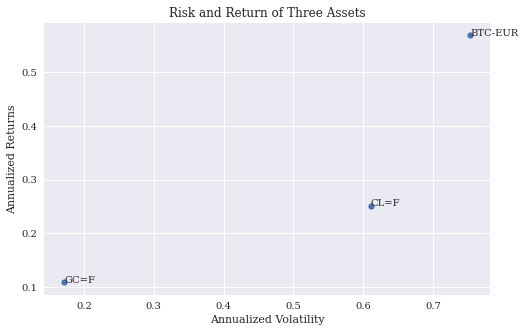

In [80]:
# Visualize each asset 
plt.figure(figsize=(8,5))
sns.scatterplot(data=table, x="Annualized Volatility", y="Annualized Returns", legend="auto")
plt.title('Risk and Return of Three Assets') 
plt.text(x=table.iloc[0]['Annualized Volatility'],y=table.iloc[0]['Annualized Returns'],s="BTC-EUR")
plt.text(x=table.iloc[1]['Annualized Volatility'],y=table.iloc[1]['Annualized Returns'],s="GC=F")
plt.text(x=table.iloc[2]['Annualized Volatility'],y=table.iloc[2]['Annualized Returns'],s="CL=F")
plt.show()

From the plot, it is clear that Bitcoin asset gives the highest return, but also highest risk, the Crude oil asset comes in second and the Gold asset give the lowest return with the lowest volatility. 

- Annualized covariance matrix:

In [81]:
rets.cov()*252

,BTC-EUR,GC=F,CL=F
BTC-EUR,0.567512,0.024661,0.064429
GC=F,0.024661,0.029527,0.011476
CL=F,0.064429,0.011476,0.373068


- Correlation matrix:

In [82]:
rets.corr()

,BTC-EUR,GC=F,CL=F
BTC-EUR,1.000000,0.190505,0.140024
GC=F,0.190505,1.000000,0.109342
CL=F,0.140024,0.109342,1.000000


Each pair of assets shows a positive correlation, which is normal since a negative correlation is hardly observed in the market. The figures that are closed to zero in the table shows that the assets have weak correlation.

### An Initial Portfolio

In the following, our major hypothesis is that investor is admitted to establish only long positions in financial instrument. Thus, it means that 100% of the investor's wealth has to be distributed across the available assets in such a way that all positions are long and that the positions total 100%.

In order to produce three uniformly distributed random numbers between 0 and 1 and then normalize the values so that the total of all values equals to 1, we use the following code:

In [83]:
weights = np.random.random(noa)
weights /= np.sum(weights)

In [84]:
weights

array([0.39843276, 0.01520378, 0.58636346])

In [85]:
weights.sum()

1.0

#### Expected return of the porfolio

Equation 1 is the formula for calculating the expected portfolio return given the individual instrument weights. In the sense that historical mean performance is regarded to be the best estimator for future (anticipated) performance, this is an expected portfolio return. 

Equation 1. General formula for expected portfolio return

$$μ_p = E(\sum_Iw_ir_i) = \sum_Iw_iE(r_i)= \sum_Iw_iμ_i = w^Tμ$$

Given the portfolio weights, the annualized portfolio return is:

In [86]:
np.sum(rets.mean()*weights)*252

0.37529426511893954

####  Expected variance of the portfolio

The expected portfolio variance is of a great significance to the MPT.

Equation 2. General formula for expected portfolio variance
$$ σ^2_p = E((r–μ)^2) = \sum_{i∈I}\sum_{j∈I}w_iw_jσ_{ij} = w^TΣw$$

The dot product of two vectors/matrices is computed using the np.dot() function.

The T attribute or transpose() method gives the transpose of a vector or matrix.

Given the portfolio variance, we can find the (expected) portfolio standard deviation or volatility.

Given the portfolio weights, annualized portfolio variance is:

In [87]:
np.dot(weights.T, np.dot(rets.cov()*252, weights))

0.2489758063810506

Given the portfolio weights, annualized portfolio volatility is:

In [88]:
math.sqrt(np.dot(weights.T, np.dot(rets.cov()*252, weights)))

0.49897475525426194

## Efficient Frontier

### Monte Carlo simulation

Knowing a portfolio with a specified weights, we can calculate return, volatility and Sharpe ratio. We will perform Monte Carlo simulation to produce random portfolios to construct efficient frontier.  
The following codes provide information regarding resulting expected portfolio variance and return, with functions port_ret() and port_vol() accordingly.

In [90]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252

In [91]:
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

In [92]:
prets = []
pvols = []
for p in range (6000):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)

The outcomes of the Monte Carlo simulation are picturized in the figure below. Moreover, the results for the Sharpe ratio, defined as $SR ≡ (μ_p–r_f)/σ_p$ — are provided in the figure

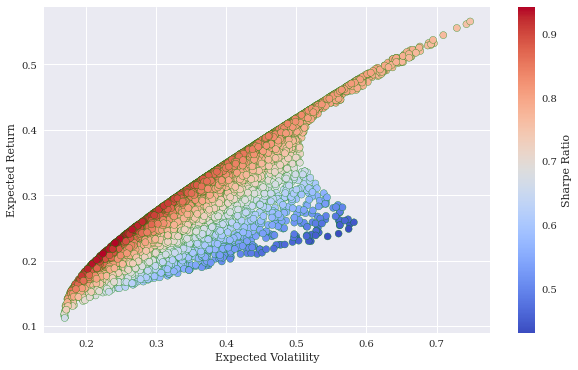

In [93]:
# Visualization of the Monte Carlo Simulation.
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm', edgecolors='green')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio');

### Minimum Variance Portfolio & Maximum Sharpe Ratio Portfolio 

#### Maximum Sharpe Ratio Portfolio 

First, the Sharpe ratio should be maximized. Formally, the Sharpe ratio's negative value is minimized in order to derive at the maximum value and the optimal portfolio composition. The constraint is that all parameters (weights) add up to 1. Weights are bound to be between 0 and 1. 

Function to be minimized:

In [94]:
def min_func_sharpe(weights):
    return -(port_ret(weights) - 0.0005) / port_vol(weights)

Equality constraint:

In [95]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

Bounds for the parameters:

In [96]:
bnds = tuple((0, 1) for x in range(noa))

Equal weights vector:

In [97]:
eweights = np.array(noa * [1. / noa,])
eweights

array([0.33333333, 0.33333333, 0.33333333])

The results are stored in an object called opts

In [98]:
opts = sco.minimize(min_func_sharpe, eweights,
                             method='SLSQP', bounds=bnds,
                             constraints=cons)

In [99]:
min_func_sharpe(opts.x)

-0.9403692534360695

###### The results from the optimization.

In [100]:
opts

     fun: -0.9403692534360695
     jac: array([-0.00224525, -0.00195266, -0.00336418])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.20347817, 0.6880952 , 0.10842663])

In [101]:
print(f"Optimal Portfolio Weights: {opts['x'].round(3)}")
print(f"Optimal Portfolio Return: {port_ret(opts['x']).round(3)}")
print(f"Optimal Portfolio Volatility: {port_vol(opts['x']).round(3)}")
print('The maximum Sharpe ratio:', port_ret(opts['x']) / port_vol(opts['x']))

Optimal Portfolio Weights: [0.203 0.688 0.108]
Optimal Portfolio Return: 0.218
Optimal Portfolio Volatility: 0.231
The maximum Sharpe ratio: 0.9425345048744747


#### Minimum Variance Portfolio

In [102]:
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)

optv

     fun: 0.16929402790686818
     jac: array([0.16927873, 0.16928669, 0.16944351])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.00391881, 0.94906063, 0.04702056])

In [103]:
mvp_weights = optv.x

In [104]:
print(f"MVP Weights: {optv['x'].round(3)}")
print(f"MVP Return: {port_ret(mvp_weights).round(2)}")
print(f"MVP Volatility: {port_vol(mvp_weights).round(2)}")
print('Sharpe ratio of MVP:', port_ret(optv['x'])/port_vol(optv['x']))

MVP Weights: [0.004 0.949 0.047]
MVP Return: 0.12
MVP Volatility: 0.17
Sharpe ratio of MVP: 0.6921995774917488


#### Efficient Frontier Visualization

Investor is generally interested in the maximum return given a fixed risk level or the minimum risk given a fixed return expectation. The so-called efficient frontier is made up of this collection of portfolios.

Definition: optimal portfolios— are all portfolios with minimum volatility for a given target return level (or all portfolios with maximum return for a given risk level)

The strategy taken is to fix a goal return level and to derive for each such level those portfolio weights that lead to the minimum volatility value. This results in two conditions for optimization: one for the desired return level, tret, and another for the sum of the portfolio weights. Each parameter's boundary values remain constant.

The two binding constraints for the efficient frontier.

In [105]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - tret}, 
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [106]:
bnds = tuple((0, 1) for x in weights)

The minimization of portfolio volatility for different target returns.

In [107]:
trets = np.linspace(0.12, 0.56, 50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

Visualizing Efficient Frontier:

The optimization results are provided in the figure below. The thick line represents the optimal portfolios for a particular target return, while the dots represent random portfolios. Furthermore, the figure depicts two larger stars, one for the minimum volatility/variance portfolio (the leftmost portfolio) and the other for the portfolio with the maximum Sharpe ratio:

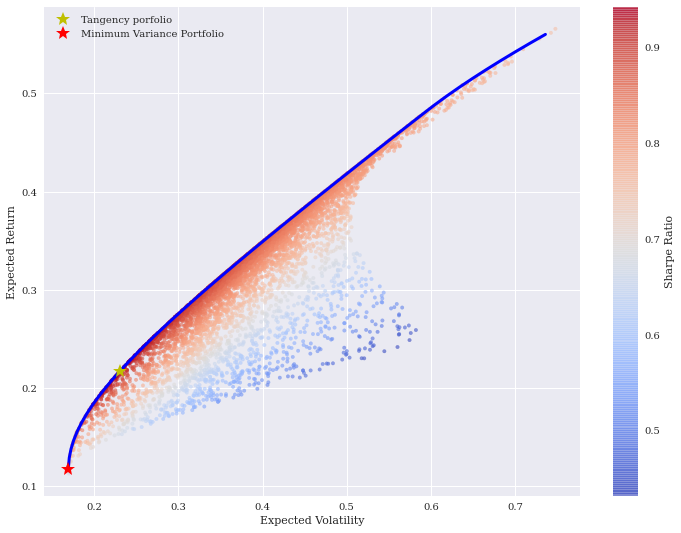

In [108]:
plt.figure(figsize=(12, 9))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.6, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=3.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0, label='Tangency porfolio')
plt.plot(port_vol(optv['x']), port_ret(optv['x']),'r*', markersize=15.0, label='Minimum Variance Portfolio')
plt.legend()
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

## Capital Allocation Line

The capital allocation line (CAL) is a line presenting all possible combinations of a risk-free asset and risky portfolio. The core concept is that investors first determine an efficient portfolio of risky assets and then add the riskless asset to the mix. It is feasible to achieve any risk-return profile that is on the straight line (in the risk-return space) between the riskless asset and the efficient portfolio by altering the proportion of the investor's wealth to be invested in the riskless asset.

The maximum Sharpe ratio we just calculate is the slope of the CAL.

A functional approximation and the first derivative for the efficient frontier are employed in the computations that follow. Such a differentiable functional approximation is provided by cubic splines interpolation. Only portfolios from the efficient frontier are considered in the spline interpolation:

Minimum volatility portfolio index position, as well as appropriate portfolio volatility and return values:

In [109]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

Cubic splines interpolation on these values:

In [110]:
tck = sci.splrep(evols, erets)

In [111]:
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)

In [112]:
def df(x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)

A linear function that represents the line in risk-return space that passes through the riskless asset and is tangent to the efficient frontier:
\begin{equation}t(x)=a+bx\end{equation} 
Three conditions that our function has to satisfy: 
\begin{equation}t(x)=a+bx\end{equation}
\begin{equation}t(0)=a  <=> a = r_{f}\end{equation}
\begin{equation}t(x)=f(x)  <=> a+bx = f(x)\end{equation}
\begin{equation}t'(x)=f'(x)  <=> b = f'(x)\end{equation}

The equations describing the capital allacation line (CAL)

In [113]:
def equations(p, rf=0.0005):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

Solving these equations for given initial values:

In [114]:
opt = sco.fsolve(equations, [0.0005, 1.1, 0.18])

The optimal parameter values:

In [115]:
opt

array([5.00000000e-04, 9.40369527e-01, 2.30979577e-01])

The equation values are all zero:

In [116]:
np.round(equations(opt),0)

array([ 0., -0.,  0.])

###### Presenting the results graphically

The star represents the optimal portfolio from the efficient frontier for which the tangent line passes through the risk-free asset point (0, rf = 0.0005):

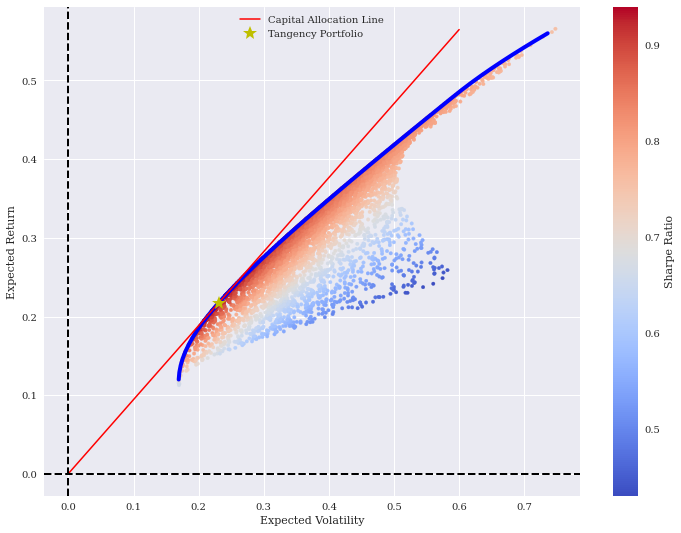

In [117]:
plt.figure(figsize=(12, 9))
plt.scatter(pvols, prets, c=(prets - 0.0005) / pvols,
                     marker='.', cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)
cx = np.linspace(0.0, 0.6)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5, label='Capital Allocation Line')
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0, label='Tangency Portfolio')
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.colorbar(label='Sharpe Ratio')

## Conslusion

- The efficient frontier is formed after the risk-return profile is checked with Monte Carlo simulation, and then the tangential portfolio is the optimal portfolio with the highest Sharpe ratio.
- The expected return and determined volatility are enough to characterize the optimal portfolio
- Other metrics included: Correlation matrix and Sharpe ratio
- The portfolio contains only commodity class (Bitcoin, Gold, and Oil) which is highly volatile. Most of the budget is spent on the Gold instrument. As far as we know, the higher a Sharpe ratio, the better its returns have been relative to the amount of investment risk taken. The Sharpe ratio of 0.94 of the tangency portfolio is considered bad, meaning that we are not being compensated very well for the risk we have taken on (return of the portfolio is less the the return of the treasure bills).

In [122]:
# Tangency portfolio
# Binding constraints for the tangent portfolio
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - f(opt[2])}, {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
# Store results
x1 = res['x'].round(3)
x2 = port_ret(res['x']).round(3)
x3 = port_vol(res['x']).round(3)
x4 = port_ret(res['x'])/port_vol(res['x'])
# Conclusion
data1 = np.array([['','Weights for BTC=EUR, GC=F, CL=F','Expected Return', 'Volatility', 'Sharpe Ratio'], 
                 ['Tangency Portfolio', res['x'].round(3), port_ret(res['x']).round(3), port_vol(res['x']).round(3), port_ret(res['x']) / port_vol(res['x'])]])
pd.DataFrame(data=data1[1:,1:], index=data1[1:,0], columns=data1[0,1:])

,"Weights for BTC=EUR, GC=F, CL=F",Expected Return,Volatility,Sharpe Ratio
Tangency Portfolio,"[0.204, 0.688, 0.109]",0.218,0.231,0.942534


With the given budget of 100,000 EUR, the allocated captital for each assets is:

In [123]:
print('Capital for BTC=EUR:', 0.204*1000000, 'EUR')
print('Capital for GC=F:', 0.688*1000000, 'EUR')
print('Capital for CL=F:', 0.109*1000000, 'EUR')

Capital for BTC=EUR: 204000.0 EUR
Capital for GC=F: 688000.0 EUR
Capital for CL=F: 109000.0 EUR


In [119]:
# MVP
data2 = np.array([['','Weights for BTC=EUR, GC=F, CL=F','Expected Return', 'Volatility', 'Sharpe Ratio'], 
                  ['Minimum Variance Portfolio', optv['x'].round(3), port_ret(mvp_weights).round(3), port_vol(mvp_weights).round(3), port_ret(optv['x'])/port_vol(optv['x'])]])
pd.DataFrame(data=data2[1:,1:], index=data2[1:,0], columns=data2[0,1:])

,"Weights for BTC=EUR, GC=F, CL=F",Expected Return,Volatility,Sharpe Ratio
Minimum Variance Portfolio,"[0.004, 0.949, 0.047]",0.117,0.169,0.6922


Source of the codes:
- https://www.statsmodels.org/
- https://pandas.pydata.org/
- https://docs.scipy.org/doc/scipy/reference/
- http://numpy.org/
- https://matplotlib.org/stable/api/
- Python for Finance, 2nd Edition, by Yves Hilpisch